In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
import copy

In [88]:
linear_trend = np.linspace(0, 10, 5)

In [92]:
x = np.linspace(0, 10 * np.pi, 10)
increasing_sine_wave = np.sin(x) + 0.1 * x  # Increasing sine wave

In [93]:
exponential_trend = np.exp(np.linspace(0, 2, 13))

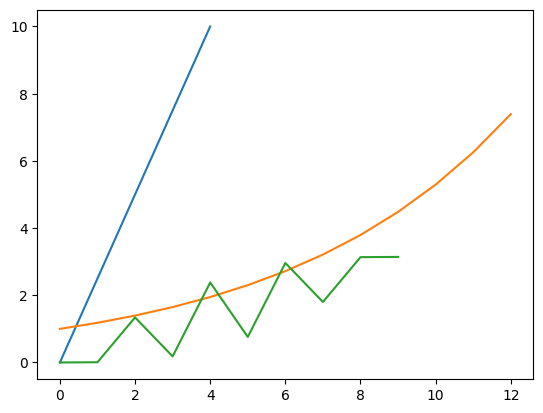

In [95]:
plt.plot(linear_trend)
plt.plot(exponential_trend)
plt.plot(increasing_sine_wave)
# plt.legend(['linear', ''])
plt.show()

In [98]:
print(linear_trend)
print(exponential_trend)
print(increasing_sine_wave)

[ 0.   2.5  5.   7.5 10. ]
[1.         1.18136041 1.39561243 1.64872127 1.94773404 2.30097589
 2.71828183 3.21127054 3.79366789 4.48168907 5.29449005 6.25470095
 7.3890561 ]
[0.         0.00704571 1.34091931 0.18117215 2.38107115 0.7605215
 2.96042051 1.80067334 3.13454695 3.14159265]


# trend data

In [156]:
np.random.seed(42)  # for reproducibility
n_samples = 10000
ages = np.concatenate([
    np.random.normal(60, 10, int(0.8 * n_samples)),  # 70% of the data around age 60
    np.random.normal(30, 10, int(0.2 * n_samples))   # 30% of the data around age 30
])
ages = np.clip(ages, 0, 100)  

In [158]:
def generate_trends(num_sequences, max_length, beta, noise):
    np.random.seed(42)  # for reproducibility
    data = {}

    for patid in tqdm(range(num_sequences)):
        length = np.random.randint(5, max_length)
        trend_type = np.random.choice(['increasing', 'decreasing'])
        x = np.linspace(0, 1, length)
        
        if trend_type == 'increasing':
            y = np.polyval(np.polyfit(x, np.random.rand(length) + np.linspace(0, 2, length), 2), x) +ages[patid]*beta
        else:
            y = np.polyval(np.polyfit(x, np.random.rand(length) + np.linspace(2, 0, length), 2), x) +ages[patid]*beta

        # Adding some noise
        y += np.random.normal(scale=noise, size=length)
        
        # Ensuring no exact linear trends
        y = y + np.sin(2 * np.pi * np.random.rand() * x)
        
        data[patid] = {}
        data[patid]['seq'] = y
        if trend_type == 'increasing':
            data[patid]['label'] = 1
        else:
            data[patid]['label'] = 0

    return data

# Generate 10 sequences with a maximum length of 50
trends_data = generate_trends(10000, 50, 0.1, 0.6)


100%|██████████| 10000/10000 [00:01<00:00, 6081.19it/s]


In [159]:
la = []
for k,v in trends_data.items():
    la.append(v['label'])

In [160]:
sum(la)

5079

6.542945507351558


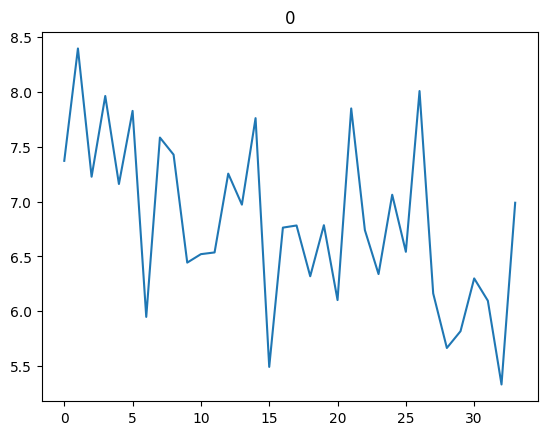

In [161]:
i = 2546
plt.plot(trends_data[i]['seq'])
plt.title(trends_data[i]['label'])
print(trends_data[i]['seq'][25])

In [162]:
import pickle
with open('datasets/noise0.6_beta0.1.pickle','wb') as handle:
    pickle.dump(trends_data, handle)

# Trend data with missingness

### missing completely at random (MCAR)

In [163]:
import copy

In [164]:
def introduce_mcar(data, missing_rate=0.6):
    np.random.seed(111)
    for patid, values in data.items():
        seq = values['seq']
        mask = np.random.rand(len(seq)) > missing_rate # if random number is greater than missing_rate, the value will be kept. As the random number is from 0 to 1 there are 1-missing_rate percent chance that the value will be kept
        seq[~mask] = np.nan  # Introducing missing values
        data[patid]['seq'] = seq
    return data

In [165]:
import pickle
with open('datasets/noise0.6_beta0.1.pickle','rb') as handle:
    trends_data = pickle.load(handle)

In [166]:
data_miss = introduce_mcar(copy.deepcopy(trends_data))

Text(0.5, 1.0, '1')

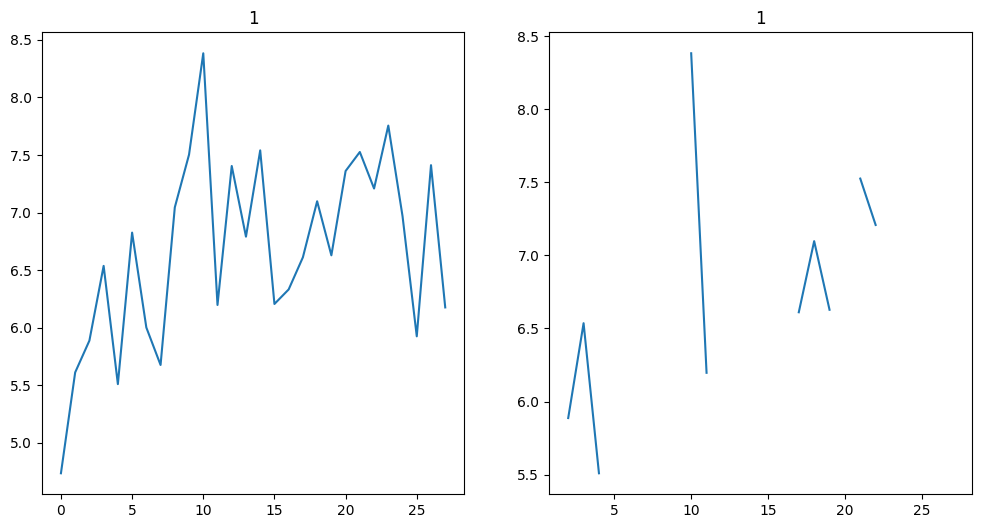

In [167]:
# miss = 0.1
i = 100
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(trends_data[i]['seq'])
axes[0].set_title(trends_data[i]['label'])

axes[1].plot(data_miss[i]['seq'])
axes[1].set_title(data_miss[i]['label'])

In [168]:
data_miss[0]

{'seq': array([9.56717963,        nan,        nan, 7.85247289,        nan,
               nan,        nan,        nan,        nan,        nan,
        8.04298938,        nan,        nan, 9.51919765, 9.07494484,
               nan,        nan,        nan,        nan, 9.14315123,
        9.37332568, 9.29095372, 8.20493469, 8.49798201,        nan,
        9.21501931,        nan,        nan,        nan,        nan,
        8.9580173 , 9.24794569,        nan,        nan, 8.53306131,
               nan, 8.44645261,        nan,        nan, 9.02728596,
               nan,        nan,        nan]),
 'label': 0}

In [169]:
for key, pat_dat in data_miss.items():
    time_stamp = np.where(~np.isnan(pat_dat['seq']))[0]
    pat_dat['timestamps'] = time_stamp

In [170]:
with open('datasets/mcar_beta0.1.pickle','wb') as handle:
    pickle.dump(data_miss, handle)

In [171]:
max_len = 0
for i, d in data_miss.items():
    if max_len<len(d['seq']):
        max_len = len(d['seq'])

In [172]:
max_len

49

### Missing at random (MAR)

### Missing not at random (MNAR)

# model training/evaluation

In [1]:
name = 'noise0.6'
model_name = 'mlp_fix'
add_annot = '_lr0.0001'

In [2]:
import pickle
with open('datasets/'+name+'.pickle','rb') as handle:
    trends_data = pickle.load(handle)

In [3]:
from training import Training
import torch
torch.cuda.set_device(0)
device = torch.device('cuda')
# training = Training(trends_data, model = model_name, device = device)
# training = Training(trends_data, model = model_name, hidden_dim = 1536, device = device)
# training = Training(trends_data, model = model_name, input_dim = 1536, hidden_dim=128, device = device)
training = Training(trends_data, model = model_name, input_dim = 49, hidden_dim=1536, device = device)

normalize data
create datasets
create trainloaders


In [5]:
import pickle
with open('outputs2/train_losses_'+model_name+'_'+name+ add_annot + '.pickle', 'rb') as handle:
    tl = pickle.load(handle)
with open('outputs2/val_losses_'+model_name+'_'+name+ add_annot + '.pickle', 'rb') as handle:
    vl = pickle.load(handle)

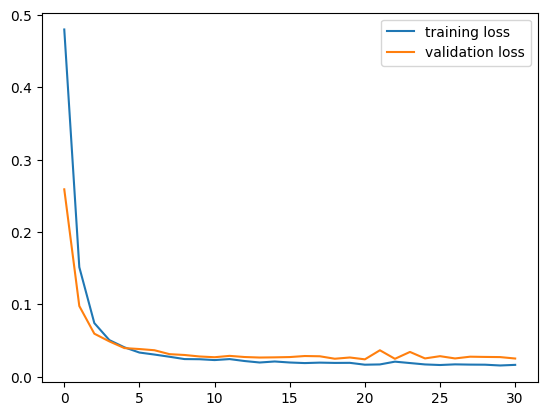

In [6]:
import matplotlib.pyplot as plt
plt.plot(tl)
plt.plot(vl)
plt.legend(['training loss', 'validation loss'])

In [7]:
test_loader = training.data_splits.test_loader

In [8]:
model = training.model
device = training.device
trained_model_path = 'outputs/baseline_'+model_name+'_'+name+add_annot+'.pt'
model.load_state_dict(torch.load(trained_model_path, map_location=device))

<All keys matched successfully>

In [9]:
trained_model_path

'outputs2/baseline_mlp_fix_noise0.6_lr0.001.pt'

In [10]:
def create_padding_mask(seq_lengths, max_len):
    batch_size = len(seq_lengths)
    mask = torch.zeros(batch_size, max_len, dtype=torch.bool)
    for i, seq_len in enumerate(seq_lengths):
        mask[i, seq_len:] = True
    return mask

In [11]:
model.eval() 
all_outputs, all_labels = [], []
with torch.no_grad():
    for sequences, labels in test_loader:
        sequences, labels = sequences.to(device), labels.float().to(device)

        seq_lengths = [len(seq[seq != 0]) for seq in sequences]  # Calculate actual lengths without padding
        max_len = sequences.size(1)
        mask = create_padding_mask(seq_lengths, max_len).to(device)
        outputs = model(sequences, mask)
        all_outputs.extend(outputs.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

In [13]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
import numpy as np

def roc_pr(outputs, labels, plot = 'no'):

    fpr, tpr, roc_thre = roc_curve(np.array(labels), np.array(outputs))
    pre, rec, pr_thre = precision_recall_curve(np.array(labels), np.array(outputs))

    if plot=='yes':
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
        roc_auc = auc(fpr, tpr)
        roc_label='AUROC'+': {:.4f}'.format(roc_auc)
        ax1.plot(fpr, tpr, color = 'b', label = roc_label)
        
        pr_auc = auc(rec, pre)
        pr_label = 'AUPR'+': {:.4f}'.format(pr_auc)
        ax2.plot(rec, pre, color='b', label=pr_label)
            
        # Set titles and labels
        ax1.set_title('ROC Curve')
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.legend(loc="lower right")
        
        ax2.set_title('Precision-Recall Curve')
        ax2.set_xlabel('Recall')
        ax2.set_ylabel('Precision')
        ax2.legend(loc="lower left")

        # Show plot
        plt.tight_layout()
        plt.show()

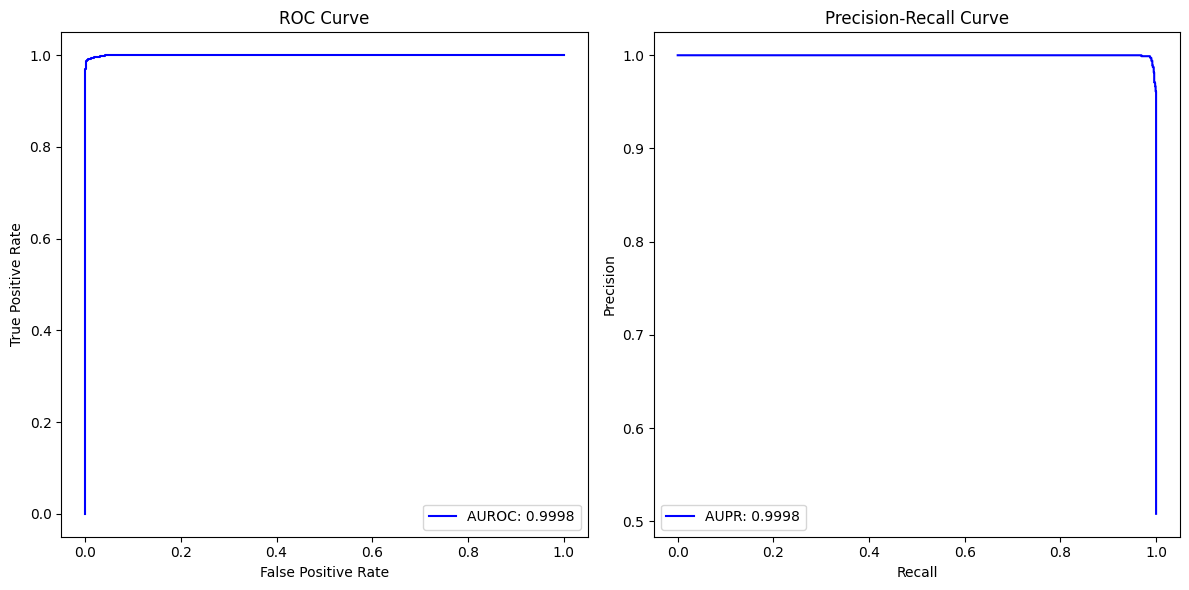

In [16]:
roc_pr(all_outputs, all_labels, plot = 'yes')